In [1]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


In [0]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import fft
from scipy.io import wavfile
from scipy.signal import find_peaks

# input: data from wav file read
# output: double[] of frequencies in fft of input
# only takes frequencies between 20 and 1000
def findFrequencies(data,minHeight):
  data = data[int(len(data) * 0.1):int(len(data)*0.9)] #taking only the middle part of the data might help get better frequencies
  fft_out = abs(fft(data))
  xaxis = np.arange(len(data)) * rate / len(fft_out)
  maximaIndices = findMaxima(fft_out,minHeight,1)[0]
  frequencies = []
  for i in range(0,len(maximaIndices)):
    # this is the part that only takes freqs from 20 to 1000, we can change it
    if (xaxis[maximaIndices[i]] > 90 and xaxis[maximaIndices[i]] < 860):
      frequencies.append(xaxis[maximaIndices[i]])
  return frequencies

def findFrequenciesExact(data,minHeight):
  data = data[int(len(data) * 0.1):int(len(data)*0.9)] #taking only the middle part of the data might help get better frequencies
  fft_out = abs(fft(data))
  xaxis = np.arange(len(data)) * rate / len(fft_out)
  maximaIndices = findMaxima(fft_out,minHeight,1)[0]
  
  maximaAtFreq = [] #a list of all intensities for first maximas
  for i in range(0,len(maximaIndices)):
    if (xaxis[maximaIndices[i]] > 90 and xaxis[maximaIndices[i]] < 860):
      maximaAtFreq.append(fft_out[maximaIndices[i]])

  indexMaxOfMaxima = findMaxima(maximaAtFreq,1,1)[0] #indices of maximaAtFreq corresponding to maximas of first maximas

  trueMaximaFrequencies = []
  for i in range(0,len(indexMaxOfMaxima)):
    trueMaximaFrequencies.append(xaxis[maximaIndices[indexMaxOfMaxima[i]]])

  return trueMaximaFrequencies
# input: 1d np array, mininmum height for maxima 
# output: int[] of the indices of all local maxima
def findMaxima(data, minHeight, minDistance):
  maxima = find_peaks(data, height = minHeight, distance = minDistance)
  return maxima

# function that smooths our data, which is useful for finding maximas.
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError ("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

48000


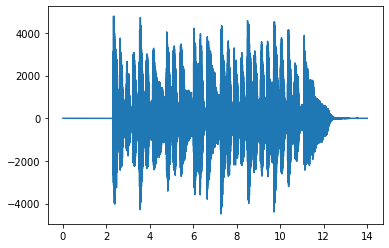

In [40]:
plt.plot(time,data)
print(rate)

# #### This is just for showing data, we don't need it for our final project
# fft_out = fft(data)
# xaxis = np.arange(len(fft_out)) * rate / len(fft_out)  
# plt.plot(xaxis,np.abs(fft_out))
# plt.xlim([20, 1000])
# ####

In [51]:
rate, data = wavfile.read('/content/drive/My Drive/UCLA/PHYSICS 4BL/Project/Mary Had A Little Lamb.wav')
data = data[:,0] #not sure why, but the data read is a 2 column array, both have similar output

time = np.arange(len(data)) * (1. / rate)

#a method to smooth data that i found online
smoothData = smooth(data)
"""minInt is an important variable that we need to adjust experimentally"""
minInt = 2000 #The minimum intensity for what is considered to be a new note, should be changed smaller probably
"""third argument needs to be adjusted"""
wavMax = findMaxima(smoothData, minInt,14000)[0] #third argument is minimum distance between maxmima. I'm not sure we actually need it since I smoothed the data 


"""
This whole section basically is the thing we discussed in lab.
It takes the wav file that is read above, and returns an array of frequencies and times (which is explained below)
"""
freqAndTimeArray = [] # this is the final output array. It is made of freqAndTimePart, which is explained below.
"""
minFreqIntensity is an important variable that we need to adjust experimentally
It is basically the minimum intensity that a frequency peak needs to be to be considered a true peak, 
and not just noise. Currently, this is set to 100,000. I imagine this is kind of low, and we can set it higher
once we record cleaner data.
"""
minFreqIntensity = 2000000  #2000000 decent
minExactFreqIntensity = 400000 
for i in range(0,len(wavMax)):
  if (i == len(wavMax)-1):
    cutData = data[wavMax[i]:(len(data)-1)]
  else:
    cutData = data[wavMax[i]:wavMax[i+1]]
  """
  Currently, findFrequencies returns too many frequencies. This might be do to there being a lot of local maximas.
  A possible solution is to just smooth the data, or I might have to adjust the way to find maxima
  """
  #smoothCutData = smooth(cutData)
  frequencies = findFrequencies(cutData,minFreqIntensity) 
  if (len(frequencies) >= 3):
    frequencies = findFrequenciesExact(cutData,minExactFreqIntensity )


  # A revised version of the thing commented out above
  # output is now only one frequency per freqAndTimePart
  # example: {[440, 0.1, 0.2], [220, 0.1, 0.2]} as opposed to method above which would return {[440, 220, 0.1, 0.2]}
  if(len(frequencies) == 0 and len(freqAndTimeArray) != 0):
    freqAndTimePart = []
    freqAndTimePart.append(1)
    # freqAndTimePart.append(freqAndTimeArray[len(freqAndTimeArray)-1][0])
    freqAndTimePart.append(time[wavMax[i]])
    if (i == len(wavMax)-1):
      freqAndTimePart.append(time[(len(data)-1)])
    else:
      freqAndTimePart.append(time[wavMax[i+1]])
    freqAndTimeArray.append(freqAndTimePart)

  for j in range(0,len(frequencies)):
    freqAndTimePart = []
    freqAndTimePart.append(frequencies[j])
    freqAndTimePart.append(time[wavMax[i]])
    if (i == len(wavMax)-1):
      freqAndTimePart.append(time[(len(data)-1)])
    else:
      freqAndTimePart.append(time[wavMax[i+1]])
    freqAndTimeArray.append(freqAndTimePart)

#freqAndTimeArray.append([0,0,0])
print(freqAndTimeArray)
print(len(freqAndTimeArray))



[[259.3481989708405, 2.3308541666666667, 2.6345], [329.3310463121784, 2.3308541666666667, 2.6345], [658.6620926243568, 2.3308541666666667, 2.6345], [293.3597621407334, 2.6345, 2.9498124999999997], [522.6788930735222, 2.9498124999999997, 3.267875], [293.65495542737284, 3.267875, 3.5658541666666665], [329.2238235804827, 3.5658541666666665, 3.8657916666666665], [329.0419662263835, 3.8657916666666665, 4.1773125], [329.06480403570043, 4.1773125, 4.781312499999999], [660.1991980338895, 4.1773125, 4.781312499999999], [297.8468899521531, 4.781312499999999, 5.129666666666666], [391.14832535885165, 4.781312499999999, 5.129666666666666], [297.2504334902155, 5.129666666666666, 5.445041666666667], [292.9508696978944, 5.445041666666667, 6.042416666666666], [585.9017393957888, 5.445041666666667, 6.042416666666666], [329.8549249172818, 6.042416666666666, 6.349375], [390.9391702723339, 6.042416666666666, 6.349375], [659.7098498345636, 6.042416666666666, 6.349375], [391.42881929383185, 6.349375, 6.64954

In [0]:
#average absolute perecnt error
arrayOfFreq = []
for i in range(0,len(freqAndTimeArray)):
  part = freqAndTimeArray[i]
  if(part[0] < 500 and part[0]>20):
    arrayOfFreq.append(part[0])
errors = []
for i in range(0,len(arrayOfFreq)):
  trueFreq = 329.63
  error = abs(arrayOfFreq[i] - trueFreq)/trueFreq
  errors.append(error)

avgPercentError = np.mean(errors) *100

print('Average percent error is ' + str(avgPercentError) + '%')

Average percent error is 0.6330217830191656%


0.3168851495726495
Tempo: 𝅘𝅥 = 95.0


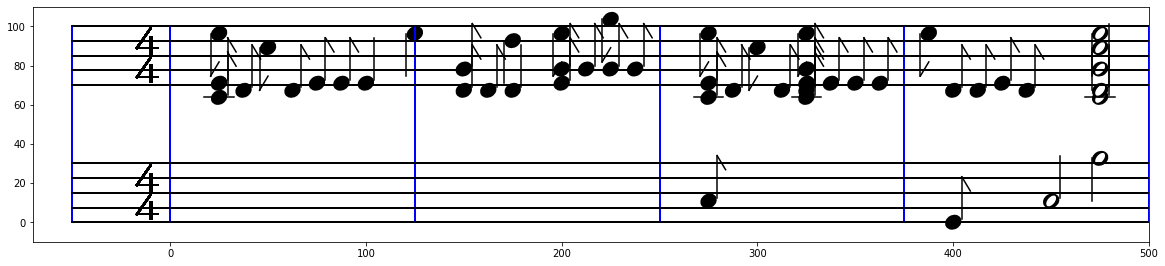

In [53]:
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
from matplotlib.patches import Ellipse
import numpy as np
from math import pi
import math

#Fixed variables
separation = 7.25 # y_axis distance between lines
x_separation = 25 # x_axis distance between each beat 
note_tempo = 0.5 #tempo the note is played at
y_position = 10 # y_axis position of each note
note_number = 10 # Determines the y_position of each note
graph_size = 20
i = 0
x_position = 0
quaver_number = 0
crochet_number = 0
minim_number = 0
dot_crochet_number = 0
quaver_time_total = 0
crochet_time_total = 0
minim_time_total = 0
dot_crochet_time_total = 0
sample_quaver_time = 10000;
bar_number = 1
total_length = 0 #Total legnth of song
old_time_start = 0
added_separation = 0
test_imputs = 10000
new_bar_number = 0

#Test variables
total_imputs = len(freqAndTimeArray)

#Sampling for quavers' time
while (i < total_imputs):
  array1 = freqAndTimeArray[i]
  freq = array1[0]
  time_start = array1[1]
  time_end = array1[2]
  time_diff = time_end - time_start
  if (sample_quaver_time >= time_diff):
    sample_quaver_time = time_diff
  i+=1

i = 0
freqAndTimeArrary = freqAndTimeArray
#Finding average quaver time
while (i < total_imputs):
  array1 = freqAndTimeArrary[i]
  freq = array1[0]
  time_start = array1[1]
  time_end = array1[2]
  time_diff = time_end - time_start
  if (time_diff < sample_quaver_time*1.5 and time_diff >= sample_quaver_time*0.75):
    quaver_time = time_diff
    quaver_number += 1
    quaver_time_total = quaver_time_total + quaver_time
    avg_quaver_time = quaver_time_total / quaver_number
  i+=1
i = 0
print(avg_quaver_time)
#Finding avg quaver, crochet and mimins' time
while (i < total_imputs):
  array1 = freqAndTimeArrary[i]
  freq = array1[0]
  time_start = array1[1]
  time_end = array1[2]
  time_diff = time_end - time_start
  if (time_diff >= avg_quaver_time*1.5 and time_diff < avg_quaver_time*2.5):
    crochet_time = time_diff
    crochet_number += 1
    crochet_time_total = crochet_time_total + crochet_time
    avg_crochet_time = crochet_time_total / crochet_number
  elif (time_diff >= avg_quaver_time*3.5):
    minim_time = time_diff
    minim_number += 1
    minim_time_total = minim_time_total + minim_time
    avg_minim_time = minim_time_total / minim_number
  elif (time_diff > avg_quaver_time*2.5 and time_diff < avg_quaver_time*3.5):
    dot_crochet_time = time_diff
    dot_crochet_number += 1
    dot_crochet_time_total = dot_crochet_time_total + dot_crochet_time
    avg_dot_crochet_time = dot_crochet_time_total / dot_crochet_number
  i+=1
i = 0




#Printing time of song
song_tempo = 60/(avg_quaver_time*2)
rounded_tempo = round(song_tempo)
print('Tempo: 𝅘𝅥 = ', end = '')
print(rounded_tempo)



#Function for converting note number to y_position
def Note_cov(note_number):
  global y_position
  if note_number == 21: #F2
    y_position = -0.5* separation  
  elif note_number == 22:  #F2#
    y_position = -0.5* separation
  elif note_number == 23: #G2
    y_position = 0*separation
  elif note_number == 24: #G2#
    y_position = 0*separation   
  elif note_number == 25: #A3
    y_position = 0.5*separation
  elif note_number == 26: #A3#
    y_position = 0.5*separation
  elif note_number == 27: #B3
    y_position = 1.* separation  
  elif note_number == 28: #C3
    y_position = 1.5* separation  
  elif note_number == 29:  #C3#
    y_position = 1.5* separation
  elif note_number == 30: #D3
    y_position = 2*separation
  elif note_number == 31: #D3#
    y_position = 2*separation   
  elif note_number == 32: #E3
    y_position = 2.5*separation
  elif note_number == 33: #F3
    y_position = 3*separation
  elif note_number == 34: #F3#
    y_position = 3.* separation  
  elif note_number == 35: #G3
    y_position = 3.5* separation  
  elif note_number == 36: #G3#
    y_position = 3.5* separation  
  elif note_number == 37: #A3
    y_position = 4.* separation  
  elif note_number == 38: #A3#
    y_position = 4.* separation  
  elif note_number == 39:  #B3
    y_position = 4.5* separation
  elif note_number == 40: #C4
    y_position = 100 - 5*separation
  elif note_number == 41: #C4#
    y_position = 100 - 5*separation   
  elif note_number == 42: #D4
    y_position = 100 - 4.5*separation
  elif note_number == 43: #D4#
    y_position = 100 - 4.5*separation
  elif note_number == 44: #E4
    y_position = 100 - 4*separation
  elif note_number == 45: #F4
    y_position = 100 - 3.5*separation   
  elif note_number == 46: #F4#
    y_position = 100 - 3.5*separation
  elif note_number == 47: #G4
    y_position = 100 - 3.*separation  
  elif note_number == 48: #G4#
    y_position = 100 - 3.*separation
  elif note_number == 49: #A4
    y_position = 100 - 2.5*separation   
  elif note_number == 50: #A4#
    y_position = 100 - 2.5*separation
  elif note_number == 51: #B4
    y_position = 100 - 2*separation     
  elif note_number == 52: #C5
    y_position = 100 - 1.5*separation 
  elif note_number == 53: #C5#
    y_position = 100 - 1.5*separation
  elif note_number == 54: #D5
    y_position = 100 - 1.*separation  
  elif note_number == 55: #D5#
    y_position = 100 - 1.*separation
  elif note_number == 56: #E5
    y_position = 100 - 0.5*separation   
  elif note_number == 57: #F5
    y_position = 100 - 0*separation
  elif note_number == 58: #F5#
    y_position = 100 - 0*separation     
  elif note_number == 59: #G5
    y_position = 100 + 0.5*separation
  elif note_number == 59: #G5#
    y_position = 100 + 0.5*separation

#Function for converting frequencies to note number 
def Freq_cov(frequency):
  global note_number


  if frequency < 89.903:
    note_number = 21 #F2
    Note_cov(note_number)    
  elif frequency < 95.25:
    note_number = 22 #F2#
    Note_cov(note_number)
  elif frequency < 100.91:
    note_number = 23 #G2
    Note_cov(note_number)    
  elif frequency < 106.91:
    note_number = 24 #G2# 
    Note_cov(note_number)
  elif frequency < 113.27:
    note_number = 25 #A2
    Note_cov(note_number)  
  elif frequency < 120:
    note_number = 26 #A2#
    Note_cov(note_number)  
  elif frequency < 127.142:
    note_number = 27 #B2
    Note_cov(note_number)
  elif frequency < 134.702:
    note_number = 28 #C3
    Note_cov(note_number)
  elif frequency < 142.71:
    note_number = 29 #C3#
    Note_cov(note_number)    
  elif frequency < 151.198:
    note_number = 30 #D3
    Note_cov(note_number)
  elif frequency < 160.19:
    note_number = 31 #D3# 
    Note_cov(note_number)    
  elif frequency < 169.714:
    note_number = 32 #E3
    Note_cov(note_number)
  elif frequency < 179.806:
    note_number = 33 #F3
    Note_cov(note_number)
  elif frequency < 190.50:
    note_number = 34 #F3#
    Note_cov(note_number)    
  elif frequency < 201.83:
    note_number = 35 #G3
    Note_cov(note_number)
  elif frequency < 213.83:
    note_number = 36 #G3#
    Note_cov(note_number)    
  elif frequency < 226.5:
    note_number = 37 #A3
    Note_cov(note_number)
  elif frequency < 240:
    note_number = 38 #A3# 
    Note_cov(note_number)    
  elif frequency < 254.4:
    note_number = 39 #B3
    Note_cov(note_number)
  elif frequency < 269.5:
    note_number = 40 #C4
    Note_cov(note_number)
  elif frequency < 286.9:
    note_number = 41 #C4#
    Note_cov(note_number)    
  elif frequency < 302.39:
    note_number = 42 #D4
    Note_cov(note_number)
  elif frequency < 320.38:
    note_number = 43 #D4# 
    Note_cov(note_number)    
  elif frequency < 339.428:
    note_number = 44 #E4
    Note_cov(note_number)
  elif frequency < 359.61:
    note_number = 45 #F4
    Note_cov(note_number)
  elif frequency < 381:
    note_number = 46 #F4#
    Note_cov(note_number)
  elif frequency < 403.65:
    note_number = 47 #G4
    Note_cov(note_number)
  elif frequency < 427.65:
    note_number = 48 #G4#
    Note_cov(note_number)    
  elif frequency < 453.08:
    note_number = 49 #A4
    Note_cov(note_number)
  elif frequency < 480:
    note_number = 50 #A4# 
    Note_cov(note_number)    
  elif frequency < 508.57:
    note_number = 51 #B4
    Note_cov(note_number)
  elif frequency < 538.8082:
    note_number = 52 #C5
    Note_cov(note_number)
  elif frequency < 570.85:
    note_number = 53 #C5#
    Note_cov(note_number)
  elif frequency < 604.79:
    note_number = 54 #D5
    Note_cov(note_number)
  elif frequency < 640.75:
    note_number = 55 #D5#
    Note_cov(note_number)
  elif frequency < 678.86:
    note_number = 56 #E5
    Note_cov(note_number)    
  elif frequency < 719.22:
    note_number = 57 #F5
    Note_cov(note_number)
  elif frequency < 761.989:
    note_number = 58 #F5# 
    Note_cov(note_number)    
  elif frequency < 807.3:
    note_number = 59 #G5
    Note_cov(note_number)
  elif frequency < 855.3:
    note_number = 60 #G5#
    Note_cov(note_number)

#Function for plotting the notes and lines

fig = plt.figure(figsize=(graph_size,graph_size))
ax = fig.add_subplot(111, aspect='equal')

def Note_plot(xy, note_tempo):
  x_position = xy[0]
  y_position = xy[1]
  x3y3 = (x_position, y_position + 0*separation)
  ells = [Ellipse((x3y3), width=separation*1.2, height=separation, angle= 30)]

  if note_tempo == 0.25:    
      #Shading notes
    for e in ells:
      ax.add_artist(e)
      #e.set_clip_box(ax.bbox)
      #e.set_alpha(rnd.rand())
      e.set_facecolor('black')
      #Plotting note ends
      if note_number <= 30 or (note_number >= 40 and note_number <= 49):
        ax.plot([x_position + separation*0.6 ,x_position + separation*0.6],[y_position+0.2*separation,y_position + 3.2*separation], color="black") #Face up
      else:
        ax.plot([x_position - separation*0.6 ,x_position - separation*0.6],[y_position,y_position - 3*separation], color="black") #Face down
      #Special case for C4
      if note_number == (40 or 41):
        ax.plot([x_position - x_separation*0.3 ,x_position + x_separation*0.3],[y_position,y_position], color="black") #Horizontal bar

  elif note_tempo == 0.375:  
    x2y2 = (x_position + 0.3*x_separation, y_position+ 0*separation)
    elles = [Ellipse(x2y2, width=separation*0.4, height=separation*0.4, angle= 30)]     
      #Shading notes
    for e in ells:
      ax.add_artist(e)
      #e.set_clip_box(ax.bbox)
      #e.set_alpha(rnd.rand())
      e.set_facecolor('black')
      #Plotting dot
    for e in elles:
      ax.add_artist(e)
      #e.set_clip_box(ax.bbox)
      #e.set_alpha(rnd.rand())
      e.set_facecolor('black')   
      #Plotting note ends
      if note_number <= 30 or (note_number >= 40 and note_number <= 49):
        ax.plot([x_position + separation*0.6 ,x_position + separation*0.6],[y_position + 0.2*separation,y_position + 3.2*separation], color="black") #Face up
      else:
        ax.plot([x_position - separation*0.6 ,x_position - separation*0.6],[y_position,y_position - 3*separation], color="black") #Face down
      #Special case for C4
      if note_number == (40 or 41):
        ax.plot([x_position - x_separation*0.3 ,x_position + x_separation*0.3],[y_position,y_position], color="black") #Horizontal bar

  elif note_tempo == 0.5:
    x1y1 = (x_position, y_position + 0*separation)
    elles = [Ellipse(x1y1, width=separation*0.9, height=separation*0.5, angle= 50)]   
      #Shading notes
    for e in ells:
      ax.add_artist(e)
      #e.set_clip_box(ax.bbox)
      #e.set_alpha(rnd.rand())
      e.set_facecolor('black')
    for e in elles:
      ax.add_artist(e)
      #e.set_clip_box(ax.bbox)
      #e.set_alpha(rnd.rand())
      e.set_facecolor('white')   
      #Plotting note ends
      if note_number <= 30 or (note_number >= 40 and note_number <= 49):
        ax.plot([x_position + separation*0.6 ,x_position + separation*0.6],[y_position+ 0.2*separation,y_position + 3.2*separation], color="black") #Face up
      else:
        ax.plot([x_position - separation*0.6 ,x_position - separation*0.6],[y_position,y_position - 3*separation], color="black") #Face down
      if note_number == (40 or 41):
        ax.plot([x_position - x_separation*0.3 ,x_position + x_separation*0.3],[y_position,y_position], color="black") #Horizontal bar

  elif note_tempo == 0.125: 
      #Shading notes
    for e in ells:      
      ax.add_artist(e)
      #e.set_clip_box(ax.bbox)
      #e.set_alpha(rnd.rand())
      e.set_facecolor('black')
      #Plotting note ends
      if note_number <= 30 or (note_number >= 40 and note_number <= 49):
        ax.plot([x_position + separation*0.6 ,x_position + separation*0.6],[y_position + 0.2*separation,y_position + 3.2*separation], color="black") #Face up
        ax.plot([x_position + separation*0.6 ,x_position + separation*1.2],[y_position + 3.2*separation,y_position + 2.2*separation], color="black") #Face up
      else:
        ax.plot([x_position - separation*0.6 ,x_position - separation*0.6],[y_position,y_position - 3*separation], color="black") #Face down
        ax.plot([x_position - separation*0.6 ,x_position],[y_position - 3*separation,y_position - 2*separation], color="black") #Face down
      if note_number == (40 or 41):
        ax.plot([x_position - x_separation*0.3 ,x_position + x_separation*0.3],[y_position,y_position], color="black") #Horizontal bar
  #Plotting temporary sharps
  sharp_values = (22,24,26,29,31,34,36,38,41,43,46,48,50,53,55,58,60)
  if note_number in (sharp_values):
    ax.plot([x_position - separation*1.0 ,x_position - separation*1.0],[y_position - 0.7*separation,y_position + 1*separation], color="black")
    ax.plot([x_position - separation*1.4 ,x_position - separation*1.4],[y_position - 0.7*separation,y_position + 1*separation], color="black")
    ax.plot([x_position - separation*1.6 ,x_position - separation*0.7],[y_position- 0.3*separation ,y_position- 0.1*separation], color="black")  
    ax.plot([x_position - separation*1.6 ,x_position - separation*0.7],[y_position+ 0.5*separation ,y_position+ 0.7*separation], color="black")     
  
  #Plotting score lines
  low_lim = -50
  upp_lim = 700
  ax.plot([-2*x_separation,-2*x_separation],[0,100], color="blue")
  ax.plot([0,0],[0,100], color="blue")
  ax.plot([5*x_separation,5*x_separation],[0,100], color="blue")
  ax.plot([10*x_separation,10*x_separation],[0,100], color="blue")
  ax.plot([15*x_separation,15*x_separation],[0,100], color="blue")
  ax.plot([20*x_separation,20*x_separation],[0,100], color="blue")
  ax.plot([25*x_separation,25*x_separation],[0,100], color="blue")
  ax.plot([30*x_separation,30*x_separation],[0,100], color="blue")
  ax.plot([low_lim,upp_lim],[100,100], color="black")
  ax.plot([low_lim,upp_lim],[92.5,92.5], color="black")
  ax.plot([low_lim,upp_lim],[85,85], color="black")
  ax.plot([low_lim,upp_lim],[77.5,77.5], color="black")
  ax.plot([low_lim,upp_lim],[70,70], color="black")
  ax.plot([low_lim,upp_lim],[30,30], color="black")
  ax.plot([low_lim,upp_lim],[22.5,22.5], color="black")
  ax.plot([low_lim,upp_lim],[15,15], color="black")
  ax.plot([low_lim,upp_lim],[7.5,7.5], color="black")
  ax.plot([low_lim,upp_lim],[0,0], color="black")

  #Plot limits of graph
  ax.set_xlim(low_lim - 20, 500)
  ax.set_ylim(-10, 110)

  #Plotting extra features
  ax.plot([-10 ,-10],[86,94], color="black",linewidth= 4)
  ax.plot([-17 ,-10],[89,99], color="black",linewidth= 2)
  ax.plot([-17 ,-6],[89,89], color="black",linewidth= 2) 
  ax.plot([-10 ,-10],[72,80], color="black",linewidth= 4)
  ax.plot([-17 ,-10],[74,84], color="black",linewidth= 2)
  ax.plot([-17 ,-6],[74,74], color="black",linewidth= 2)


  ax.plot([-10 ,-10],[16,24], color="black",linewidth= 4)
  ax.plot([-17 ,-10],[19,29], color="black",linewidth= 2)
  ax.plot([-17 ,-6],[19,19], color="black",linewidth= 2) 
  ax.plot([-10 ,-10],[2,10], color="black",linewidth= 4)
  ax.plot([-17 ,-10],[4,14], color="black",linewidth= 2)
  ax.plot([-17 ,-6],[4,4], color="black",linewidth= 2)



#Converting notes to outputs
initial_array = freqAndTimeArray[0]
old_time_start = initial_array[1]
x_position += x_separation
while (i < total_imputs):


  array1 = freqAndTimeArray[i]
  frequency = array1[0]
  time_start = array1[1]
  time_end = array1[2]
  time_diff = time_end - time_start
  note_time_diff = abs(old_time_start - time_start)
  old_time_start = time_start

  if (note_time_diff >= 0.5*avg_quaver_time): #Plotting notes on different places if time stamp is different
    if (time_diff < avg_quaver_time*1.5 and time_diff >= avg_quaver_time*0.75):
      note_tempo = 0.125
      Freq_cov(frequency)
      Note_plot((x_position, y_position), note_tempo)
      added_separation = x_separation*0.5

    elif (time_diff >= avg_quaver_time*1.5 and time_diff < avg_quaver_time*2.5):
      note_tempo = 0.25
      Freq_cov(frequency)
      Note_plot((x_position, y_position), note_tempo)
      added_separation = x_separation*1

    elif (time_diff > avg_quaver_time*2.5 and time_diff < avg_quaver_time*3.5):
      note_tempo = 0.375
      Freq_cov(frequency)
      Note_plot((x_position, y_position), note_tempo)
      added_separation = x_separation*1.5

    elif (time_diff >= avg_quaver_time*3):
      note_tempo = 0.5
      Freq_cov(frequency)
      Note_plot((x_position, y_position), note_tempo)
      added_separation = x_separation*2
    x_position = x_position + added_separation


  else:
    x_position = x_position - added_separation
    if (time_diff < avg_quaver_time*1.5 and time_diff >= avg_quaver_time*0.75):
      note_tempo = 0.125
      Freq_cov(frequency)
      Note_plot((x_position, y_position), note_tempo)
      added_separation = x_separation*0.5

    elif (time_diff >= avg_quaver_time*1.5 and time_diff < avg_quaver_time*2.5):
      note_tempo = 0.25
      Freq_cov(frequency)
      Note_plot((x_position, y_position), note_tempo)
      added_separation = x_separation*1

    elif (time_diff > avg_quaver_time*2.5 and time_diff < avg_quaver_time*3.5):
      note_tempo = 0.375
      Freq_cov(frequency)
      Note_plot((x_position, y_position), note_tempo)
      added_separation = x_separation*1.5

    elif (time_diff >= avg_quaver_time*3):
      note_tempo = 0.5
      Freq_cov(frequency)
      Note_plot((x_position, y_position), note_tempo)
      added_separation = x_separation*2
    x_position = x_position + added_separation
  new_bar_number = x_position / (5*x_separation)
  if (new_bar_number >= bar_number): #If we are not in the same bar
    bar_number += 1
    x_position += x_separation
  i+=1
i = 0

#plt.show()